In [291]:
import pandas as pd
import numpy as np
from scipy import stats
from rpy2.robjects import r
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import matplotlib.pyplot as plt
%matplotlib inline

## Is there a "hot hand" effect in basketball?

Is a player that gets a single shot in more likely to get their next shot in? Is hitting a shot dependent on previously having hit a shot?

Let's explore the hot hand streaks with some of Kobe Bryant's shot data.

### The Data

[Based off this probability lab from Coursera's Stats With R course](https://github.com/StatsWithR/labs/blob/master/1.3_probability/probability.Rmd)

Kobe's shots per game in the LAL v. Orlando 2009 playoff series:

In [136]:
data = pd.read_csv("data/kobe_hothand.csv")
data.head(15)

,Unnamed: 0,vs,game,quarter,time,description,shot
0,1,ORL,1,1,9:47,Kobe Bryant makes 4-foot two point shot,H
1,2,ORL,1,1,9:07,Kobe Bryant misses jumper,M
2,3,ORL,1,1,8:11,Kobe Bryant misses 7-foot jumper,M
3,4,ORL,1,1,7:41,Kobe Bryant makes 16-foot jumper (Derek Fisher...,H
4,5,ORL,1,1,7:03,Kobe Bryant makes driving layup,H
5,6,ORL,1,1,6:01,Kobe Bryant misses jumper,M
6,7,ORL,1,1,4:07,Kobe Bryant misses 12-foot jumper,M
7,8,ORL,1,1,0:52,Kobe Bryant misses 19-foot jumper,M
8,9,ORL,1,1,0:00,Kobe Bryant misses layup,M
9,10,ORL,1,2,6:35,Kobe Bryant makes jumper,H


We have 133 shots worth of data to evaluate, with 75 shots missed and 58 shots made. These shots come from a playoff series with 5 games.

In [68]:
pd.DataFrame(data.shot.value_counts()).T

,M,H
shot,75,58


In [69]:
data.shape

(133, 7)

In [70]:
shots_game= pd.DataFrame(data.game.value_counts().sort_index())
shots_game.columns = ["shots_per_game"]
shots_game.T

,1,2,3,4,5
shots_per_game,34,21,25,30,23


On average, Kobe's average shots made for this series is:

In [71]:
shots_made_avg = 58/133
shots_made_avg

0.43609022556390975

This is probably a good place to note that we're looking at all types of different shots (layups, jumpers, shots with different distances, etc). This could potentially be something to come back and consider in terms of confounders but for now we'll table this and move forward with exploring our shot data.

### Finding Streaks

The idea here is to loop through Kobe's 133 shots and find sets of consecutive shots. 

In [72]:
# defining a streak calculator function based off this excercise:
# https://github.com/StatsWithR/labs/blob/master/1.3_probability/probability.Rmd

def calc_streak(data):
    
    streak = []
    count = 0
    
    for shot in data:
        
        if shot == "H":
            count +=1
            
        elif shot == "M":
            streak.append(count)
            count = 0
            
    return streak

#### Kobe's shot streaks throughout the series

In [73]:
kobe_streak = calc_streak(data['shot'])

In [78]:
kobe_streak = pd.DataFrame(kobe_streak, columns=["streaks"])

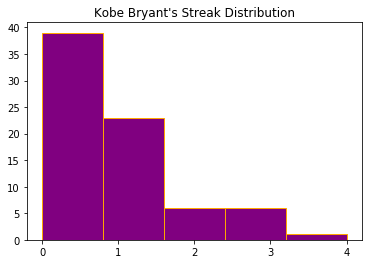

In [149]:
plt.hist(kobe_streak.streaks, bins=5, edgecolor='orange', linewidth=1, color="purple")
plt.xticks(range(0,5))
plt.title("Kobe Bryant's Streak Distribution")
plt.show()

In [14]:
kobe_streak_summary = pd.DataFrame(kobe_streak.streaks.value_counts().sort_index()).T
kobe_streak_summary

,0,1,2,3,4
streaks,39,23,6,6,1


In this series, Kobe had 6 x 2-shot streaks, 6 x 3-shot streaks, and 1 x 4-shot streaks. 

At this moment, I'm not as interested in missed shot streaks (or cold hand streaks) and 1-shot streaks. Though this is definitely something that could be explored further.

### Is Kobe's streak distribution special?

... If we randomly generate 133 _independant_ shots, with the same rate of success as Kobe (for this playoff series at least)-- what kind of distribution do we see?

The interesting thing to keep in mind here with our simulated data is that we'll be looking at shot streak distributions of randomly generated _independent_ shots.    

The idea here is to examine what shot streaks look like for independent shots, and compare this with Kobe's shots.   

If our simulated streak distribution looks the same as Kobe's streak distribution, we can argue that this weakens the argument for the 'hot hand' theory.

#### Simulating a random player's streak

To simulate shot streaks, we'll first simulate 133 independent shots from a binomial distribution with the probability for a succesful shot being the same as Kobe's average success rate for this particular series.

Once we have a set of 133 simulated shots from our binomial distribution of choice, we can find streaks and plot our distribution of streaks.

In [80]:
#just a reminder of Kobe's avg success rate for this data set:
round(shots_made_avg,2)

0.44

In [88]:
#generating a set of 133 independent shots from a binomial distribution

n = 1 #1 shot per trial
p = shots_made_avg #success rate
trials = 133 #nubmer of trials

player_1 = np.random.binomial(n,p,trials)

In [89]:
#cleaning our shot set to make it comparable with our Kobe data
# 1 is a 'Hit' and 0 is a 'Miss'

player_1 = list(player_1)

for j in range(len(player_1)):
    if player_1[j] == 1:
        player_1[j] ="H"
    else:
        player_1[j] = "M"

In [90]:
player_1_streak = calc_streak(player_1)
player_1_streak = pd.DataFrame(player_1_streak, columns=["streaks"])

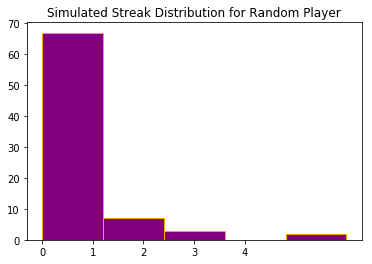

In [150]:
plt.hist(player_1_streak.streaks, bins=5, edgecolor='orange', linewidth=1, color="purple")
plt.xticks(range(0,5))
plt.title("Simulated Streak Distribution for Random Player")
plt.show()

In [92]:
pd.DataFrame(player_1_streak.streaks.value_counts().sort_index()).T

,0,1,2,3,5,6
streaks,47,20,7,3,1,1


Our Random Player's streak distribution looks sort of similar to Kobe's streak distribution. Both streak distributions are skewed left.

...
Does this change if we simulate 1,000 random players' streaks?

#### Simulating 1,000 random players' streaks

Using the same simulation setup as above but this time for 1,000 random Kobe-like players:

In [299]:
sims = []

for player in range(1000):
    n = 1
    p = shots_made_avg
   
    player_shots = np.random.binomial(n,p,133)
    player_shots = list(player_shots)
    
    for j in range(len(player_shots)):
        if player_shots[j] == 1:
            player_shots[j] ="H"
        else:
            player_shots[j] = "M"
    
    player_streak = calc_streak(player_shots)
    player_streak = pd.DataFrame(player_streak, columns=["streaks"])
    sims.append(dict(player_streak.streaks.value_counts().sort_index()))


In [300]:
#cleaning up our simulations and compiling them into one dataframe
sims_df = pd.DataFrame(sims).fillna(0)

#looking at the first 10 simulations
sims_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,13,14
0,45,14,9.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,46,20,9.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,50,21,4.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,45,14,6.0,2.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,50,17,9.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [301]:
#Getting some descriptive stats for our collection of 1k streaks
sim_summary = sims_df.agg(['min', 'max', 'mean', 'median', 'std']).round(decimals=2).T

#Looking only at 2-shot, 3-shot, and 4-shot streaks:
sim_summary[2:5]

,min,max,mean,median,std
2,0.0,18.0,7.91,8.0,2.58
3,0.0,9.0,3.41,3.0,1.75
4,0.0,6.0,1.50,1.0,1.14


In [302]:
sim_summary["std"][4]

1.14

How do Kobe's streaks fare with the 1k shot streak simulations?

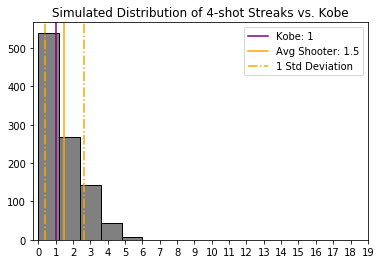

In [307]:
sims_df[4].hist(bins=5, edgecolor='black', linewidth=1, color='grey')
plt.xticks(range(0,20))
plt.grid()
#Kobe's streak count
plt.axvline(x=kobe_streak_summary[4]['Kobe_Streaks'], color='purple', label='Kobe: '+str(kobe_streak_summary[4]['Kobe_Streaks']))

#Average
plt.axvline(x=np.mean(sims_df[4]), color='orange', label='Avg Shooter: '+str(round(np.mean(sims_df[4]),2)))

#conf. intervals
plt.axvline(x=np.mean(sims_df[4])+sim_summary["std"][4], color='orange', linestyle='-.', label
            ="1 Std Deviation")
plt.axvline(x=np.mean(sims_df[4])-sim_summary["std"][4], color='orange', linestyle='-.')

plt.title('Simulated Distribution of 4-shot Streaks vs. Kobe')
plt.legend()
plt.show()

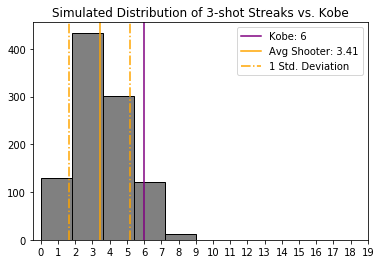

In [308]:
sims_df[3].hist(bins=5, edgecolor='black', linewidth=1, color='grey')
plt.xticks(range(0,20))
plt.grid()
plt.axvline(x=kobe_streak_summary[3]['Kobe_Streaks'], color='purple', label='Kobe: '+str(kobe_streak_summary[3]['Kobe_Streaks']))
plt.axvline(x=np.mean(sims_df[3]), color='orange', label='Avg Shooter: '+str(round(np.mean(sims_df[3]), 2)))

plt.axvline(x=np.mean(sims_df[3])+sim_summary["std"][3], color='orange', linestyle='-.', label="1 Std. Deviation")
plt.axvline(x=np.mean(sims_df[3])-sim_summary["std"][3], color='orange', linestyle='-.')

plt.legend()
plt.title('Simulated Distribution of 3-shot Streaks vs. Kobe')
plt.show()

Whoa-- does Kobe have a sweet spot for 3-shot streaks?

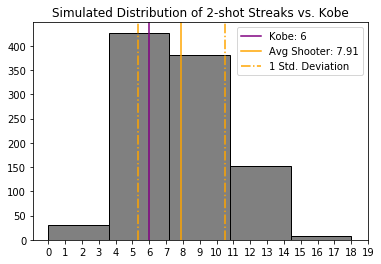

In [309]:
sims_df[2].hist(bins=5, edgecolor='black', linewidth=1, color='grey')
plt.xticks(range(0,20))
plt.grid()
plt.axvline(x=kobe_streak_summary[2]['Kobe_Streaks'], color='purple', label='Kobe: '+str(kobe_streak_summary[2]['Kobe_Streaks']))
plt.axvline(x=np.mean(sims_df[2]), color='orange', label='Avg Shooter: '+str(round(np.mean(sims_df[2]), 2)))

plt.axvline(x=np.mean(sims_df[2])+sim_summary["std"][2], color='orange', linestyle='-.', label='1 Std. Deviation')
plt.axvline(x=np.mean(sims_df[2])-sim_summary["std"][2], color='orange', linestyle='-.')

plt.legend()
plt.title('Simulated Distribution of 2-shot Streaks vs. Kobe')
plt.show()

_** TBC **

#### Hypothesis Testing using the Chi-Squared Test

Source: https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

... Perhaps we can do more rigourous testing using our simulations beyond comparing distributions.

Null Hypothesis --  $H_0$: Streaks are random. There's no association between Kobe's awesome and streaks.

In [340]:
sims_streak_sum = pd.DataFrame(sims_df.iloc[:,0:4].sum(), columns=["Sims_Streaks"]).T
sims_streak_sum

,0,1,2,3
Sims_Streaks,42699.0,18399.0,7909.0,3414.0


In [344]:
kobe_streak_summary.index=['Kobe_Streaks']
kobe_streak_summary_t = kobe_streak_summary.drop(columns=[4])
kobe_streak_summary_t

,0,1,2,3
Kobe_Streaks,39,23,6,6


In [345]:
chi_table = pd.concat([sims_streak_sum,kobe_streak_summary_t], axis=0)
chi_table

,0,1,2,3
Sims_Streaks,42699.0,18399.0,7909.0,3414.0
Kobe_Streaks,39.0,23.0,6.0,6.0


In [346]:
def apply_chi(prob, c_table):

    stat, p, dof, expected = chi2_contingency(c_table)
    print(" Calculated Statistic: ",stat,
      "\n P-value: ", p,
     "\n Degrees of Freedom: ", dof)
    
    critical = chi2.ppf(prob, dof)
    alpha = 1.0 - prob
    print("======================\n")
    print("1. Is the observed statistic (", round(stat,2),") greater than the chi-test critical value (",round(critical,2),") ? \n")

    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('     No. We fail to reject H0. \n')
        
    
    print("2. Is the p-value (", round(p,2),") less than our significance level of (",round(alpha,2),") ? \n")

    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('     No. We fail to reject H0.')

In [347]:
#when comparing all streaks from 0 to 4-shot streaks
apply_chi(0.95, chi_table)

 Calculated Statistic:  3.7686897642849666 
 P-value:  0.2875491018300517 
 Degrees of Freedom:  3

1. Is the observed statistic ( 3.77 ) greater than the chi-test critical value ( 7.81 ) ? 

     No. We fail to reject H0. 

2. Is the p-value ( 0.29 ) less than our significance level of ( 0.05 ) ? 

     No. We fail to reject H0.


#### Fisher Exact Test

In this case, we fail to reject the $H_0$.

In [337]:
#2-shot streaks and 3-shot streaks
ft2_3 = chi_table.drop(columns=[0,1,4])

oddsratio, pvalue = stats.fisher_exact(ft2_3)
print("Fisher Exact Test, p-value: ", pvalue)
ft2_3

Fisher Exact Test, p-value:  0.20348157339384165


,2,3
Sims_Streaks,7909.0,3414.0
Kobe_Streaks,6.0,6.0


## HMMs

_** mostly a tbc section **_

In [54]:
from collections import defaultdict
from collections import Counter

In [55]:
corpus = list(data.shot)
corpus = ''.join(corpus)
corpus

'HMMHHMMMMHHHMHHMMHHHMMHMHHHMMMMMMHMHMMHHHHMHMMHMMHMMHMHHMMHMHHMHMMMHMMMMHMHMMHMMHHMMMMHHHMMHMMHMHHMHMMHMMMHMHHHMHHHMHMHMMMMMMHMHMMMMH'

In [56]:
n = 1
circ_corpus = corpus + corpus[:n]
frequencies = defaultdict(Counter)
for i in range(len(circ_corpus) - n):
    frequencies[circ_corpus[i:i + n]][circ_corpus[i + n]] += 1
frequencies

defaultdict(collections.Counter,
            {'H': Counter({'H': 22, 'M': 36}),
             'M': Counter({'H': 36, 'M': 39})})

In [57]:
ccm = pd.DataFrame(frequencies).fillna(0)
ccm.columns = ['Miss', 'Hit']
ccm.index =  ['Miss', 'Hit']
ccm

,Miss,Hit
Miss,22,36
Hit,36,39


In [58]:
t_ccm = ccm.copy()

In [354]:
for j,i in enumerate(ccm.index):
    #J row label
    #I row index number
    t_ccm.loc[i] = t_ccm.loc[i].divide(t_ccm.sum(axis=1)[j])
t_ccm

,Miss,Hit
Miss,0.37931,0.62069
Hit,0.48000,0.52000


These are transition probabilities!

In [359]:
prob_MH = (1-shots_made_avg) * t_ccm["Hit"][0]
prob_MH

0.3500129634430905

In [361]:
prob_HH = (shots_made_avg) * t_ccm["Hit"][1]
prob_HH

0.2267669172932331

In [356]:
prob_HHH = shots_made_avg * t_ccm["Hit"]["Hit"] * t_ccm["Hit"]["Hit"]
prob_HHH

0.11791879699248121

In [357]:
prob_HMH = shots_made_avg * t_ccm["Hit"][0] * t_ccm["Miss"][1]
prob_HMH

0.12992481203007517

In [358]:
prob_HMM = shots_made_avg * t_ccm["Hit"][0] * t_ccm["Miss"][0]
prob_HMM

0.10267046927663986

In [348]:
data.head(15)

,Unnamed: 0,vs,game,quarter,time,description,shot
0,1,ORL,1,1,9:47,Kobe Bryant makes 4-foot two point shot,H
1,2,ORL,1,1,9:07,Kobe Bryant misses jumper,M
2,3,ORL,1,1,8:11,Kobe Bryant misses 7-foot jumper,M
3,4,ORL,1,1,7:41,Kobe Bryant makes 16-foot jumper (Derek Fisher...,H
4,5,ORL,1,1,7:03,Kobe Bryant makes driving layup,H
5,6,ORL,1,1,6:01,Kobe Bryant misses jumper,M
6,7,ORL,1,1,4:07,Kobe Bryant misses 12-foot jumper,M
7,8,ORL,1,1,0:52,Kobe Bryant misses 19-foot jumper,M
8,9,ORL,1,1,0:00,Kobe Bryant misses layup,M
9,10,ORL,1,2,6:35,Kobe Bryant makes jumper,H
